## Automatic parallel computing of raster slit scan timeseries densities of DKIST Cryo-NISRP or DL-NIRSP data

## Input data are matching pairs of Fe XIII 1074.6nm and 1079.8nm reduced observations of >=Level-1.

The **DKIST_DENS** function needs a chianti help file which is included in this repository.

Input data and metadata can be single slit positions or raster scans of observations (single-dimension to three-dimensional arrays).

The function can process peak line emission or integrated line observations, provided the required parameters for each case are provided.

The **work_1pix** worker function is required for the parallel implementation.

These scripts are provided "as-is", are not free of bugs, and nor safe from improper usage. Please mind inherent assumptions.

More information on the method and software codes can be found in [Paraschiv & Judge, 2022](https://ui.adsabs.harvard.edu/abs/2022SoPh..297...63P/abstract) and [Schad & Dima, 2020](https://ui.adsabs.harvard.edu/abs/2020SoPh..295...98S/abstract).

Contact: Alin Paraschiv, NSO ---- arparaschiv at nso edu

In [10]:
import numpy as np              ## in DKIST_DENS
import multiprocessing          ## in DKIST_DENS
from tqdm import tqdm           ## in DKIST_DENS
from scipy.io import readsav    ## in DKIST_DENS; only if using the deprecated sswidl table
from scipy import interpolate   ## in work_1pix 

def DKIST_DENS(i1074,i1079,chianti_link,header_1074,header_1079,integrated=False):
## compute the density from two stokes I observations (serialized parallel runs for 1 pix at a time) of Fe XIII assuming:
##    - a line ratio look-up table created using chianti atomic data. 
##    - accurate header pointing information
##    - that the arrays are aligned properly
##    - others ??

## function should process single-dimensional, or bi-dimensional input arrays of 1 OR 3 emission line fit parameters. Input array dimension should be between 1 and 3.
##       The input arrays contain EITHER peak intensity, OR peak intensity, wavelength center position, and distribution sigma if integrated=True is passed; e.g. 
##       [slitsize]                               --single slit position, only peak intensity
##       [slitsize,fit_params]                    --single slit position, peak intensity, center, and sigma.
##       [number_of_steps,slit_size]              --raster of slit positions, only peak intensity
##       [number_of_steps,slit_size,fit_params]   --raster of slit positions,  peak intensity, center, and sigma.

## - Two chianti look-up tables are computed via PyCELP or SSWIDL(deprecated) and imported via the "chianti_link" path given to this function.
## - Requires full observation headers (1 header per slit step) from both Fe XIII line datasets.
## - Requires the numpy, multiprocessing, tqdm, scipy's interpolate and io.readsav imports 
    
## input ingestion and return array. Sanity checks will return 0 in case something is incompatible.
    
    ## single slit position with only peak intensity.
    if np.ndim(i1074) == 1:
        density=np.zeros(i1074.shape,dtype=np.float32)   ## single-dimensional spatial array of peak intensities
        if integrated:
            print("Not enough parameter inputs for integrated line calculations. Aborting!")
            return density    
        if (i1074.shape != i1079.shape):   ## sanity check 
            print("Arrays are not of the same physical shape. Aborting!")
            return density
        print('Single slit position of peak intensity ingested. Continuing!')        
    
    ## two sub-combinations of inputs.
    elif np.ndim(i1074) == 2:
        if integrated:                                                                ## understand a single slit with 3 fit parameters
            density=np.zeros(i1074.shape[0],dtype=np.float32)   
            if (i1074.shape[0] != i1079.shape[0]):   ## sanity check 
                print("Arrays are not of the same physical shape. Aborting!")
                return density
            print('Single slit position with peak, center and standard deviation parameters are ingested. Continuing!')
        else:                                                                         ## understand a raster of slits with only peak intensity.
            density=np.zeros(i1074.shape,dtype=np.float32)   
            if (i1074.shape != i1079.shape):   ## sanity check 
                print("Arrays are not of the same physical shape. Aborting!")
                return density
            print('Raster of slit positions of only peak intensity ingested. Continuing!')
    
    ## bi-dimensional spatial array with added 3rd dimension for peak, center an standard deviation of coronal line.
    ## not capturing if more than three fit parameters are ingested. 
    elif np.ndim(i1074) == 3:      
        density=np.zeros(i1074.shape[:2],dtype=np.float32)
        if (i1074.shape[:2] != i1079.shape[:2]):   ## sanity check 
            print("Arrays are not of the same physical shape. Aborting!")
            return density
        if i1074.shape[2] < 3:
            print("Not enough parameter inputs for integrated line calculations. Aborting!")
            return density
        print('Raster of slit positions with peak, center and standard deviation parameters are ingested. Continuing!')
        
    ## Input not compatible with this function
    else:
        print("input array dimensions not understood. Aborting!")
        return np.zeros((2,2))


    ## theoretical chianti ratio calculations created via PyCELP or SSWIDL        
    ## read the chianti table         
    if (chianti_link[-4:]    == ".npz"):                     ## default
        chianti_table        =  dict(np.load(chianti_link))  ## variables (h,den,rat) directly readable by work_1pix .files required for loading the data directly.
    elif (chianti_link[-4:]  == ".sav"):                     ## deprecated
        print("The sswidl look-up table is deprecated. The pycelp look-up table is better supported and recommended at this stage")
        chianti_table        =  readsav(chianti_link)        ## variables  (h,den,rat) directly readable by work_1pix
        chianti_table["den"] =  chianti_table["den"][0,:]    ## density sample values are the same at all heights. Use just one instance.
    else:
        print("Chianti look-up table not found. Is the path correct?")
        return density                                ## a zero array at this point
    #print(chianti_table.keys())               ## Debug - check the arrays
    
    ##  in the save files:
    ## 'h' is an array of heights in solar radii ranged 1.01 - 2.00(pycelp) or 1.01 - 1.50(sswidl);  
    ## 'den' is an array of density (ranged 6.00 to 12.00 (pycelp) or 5.0 to 13.0 (sswidl); the broader interval is not really recommended here. 
    ## 'rat' is a 2D array containing line ratios corresponding to the density range values at each distinct height.
    
    ##  To query the look-up table:
    ##  print(chia['h'],chia['h'].shape,chia['rat'].shape,chia['den'].shape)

    ## look-up table resolutions
    ## pycelp: h is of shape [99]; den and rat are arrays of shape [99, 120] corresponding to the 99 h height values and 120 density values
    ## sswidl: h is of shape [50]; den and rat are arrays of shape [50,  33] corresponding to the 50 h height values and  33 density values

## set up the cpu worker and argument arrays
    p          = multiprocessing.Pool(processes=multiprocessing.cpu_count()-2,maxtasksperchild = 10000)     ##ncpus = 54  ## dynamically defined from system query as total CPU core number - 2
    ## argument index keeper for splitting tasks to cpu cores
    ## two branches to separate slingle slits vs rasters
    arg_array  = []
    
    if np.ndim(i1074) == 1 or (np.ndim(i1074) == 2 and integrated):                                        ## Single slit branch
        for ypos in range(i1074.shape[0]): 
            arg_array.append((0,ypos,i1074[ypos],i1079[ypos],header_1074[0],header_1079[0],chianti_table,integrated))        
        rs     = p.starmap(work_1pix,arg_array)
        p.close()
        pbar   = tqdm(total=len(arg_array))  ## progress bar implmentation via tqdm
        for i,res in enumerate(rs):
            step,ypos,density[ypos] = res    ## step is just a dummy in this case; Density defined as a single-dimension vector in this case.
            pbar.update()
        pbar.close()
   
    else:                                                                                                  ## Raster slit branch
        for step in range(i1074.shape[0]): 
            for ypos in range(i1074.shape[1]): 
                arg_array.append((step,ypos,i1074[step,ypos],i1079[step,ypos],header_1074[step],header_1079[step],chianti_table,integrated))

        rs     = p.starmap(work_1pix,arg_array)
        p.close()
        pbar   = tqdm(total=len(arg_array))  ## progress bar implmentation via tqdm
        for i,res in enumerate(rs):
            step,ypos,density[step,ypos] = res 
            pbar.update()
        pbar.close()

    return density

def work_1pix(xx,yy,a_obs,b_obs,a_hdr_1pix,b_hdr_1pix,chianti_table,integrated):
    ## compute the ratio of the observation ## 1074/1079 fraction, same as rat component of the chianti_table 
    
    ## Sanity checks at pixel level
    if integrated and b_obs[0] == 0:                    ## don't divide by 0
        return xx,yy,0                                  ## return 0 value
    elif integrated == False and b_obs == 0:
        return xx,yy,0                                  ## return 0 value
   
    ## line ratio calculations for peak and integrated quantities
    ## Ratios of integrated line counts, requires amplitude, distribution center and sigma parameters
    if integrated:
        #rg_a = np.linspace(a_hdr_1pix["CRVAL1"]-(a_hdr_1pix["NAXIS1"]/2)*a_hdr_1pix["CDELT1"],a_hdr_1pix["CRVAL1"]+(a_hdr_1pix["NAXIS1"]/2)*a_hdr_1pix["CDELT1"], a_hdr_1pix["NAXIS1"]) ## Tom cnPipeline version, makes the assumption of the wavelength reference being in the center of the wavelength axis space
        #rg_b = np.linspace(b_hdr_1pix["CRVAL1"]-(b_hdr_1pix["NAXIS1"]/2)*b_hdr_1pix["CDELT1"],b_hdr_1pix["CRVAL1"]+(b_hdr_1pix["NAXIS1"]/2)*b_hdr_1pix["CDELT1"], b_hdr_1pix["NAXIS1"])
        
        rg_a = np.linspace(a_hdr_1pix["CRVAL1"]-(a_hdr_1pix["CRPIX1"])*a_hdr_1pix["CDELT1"],a_hdr_1pix["CRVAL1"]+(a_hdr_1pix["NAXIS1"]-a_hdr_1pix["CRPIX1"])*a_hdr_1pix["CDELT1"],a_hdr_1pix["NAXIS1"]) ## FITS conforming version (Datacenter?), uses the CRVAL1 keyword for reference. Unclear implementation. 
        rg_b = np.linspace(b_hdr_1pix["CRVAL1"]-(b_hdr_1pix["CRPIX1"])*b_hdr_1pix["CDELT1"],b_hdr_1pix["CRVAL1"]+(b_hdr_1pix["NAXIS1"]-b_hdr_1pix["CRPIX1"])*b_hdr_1pix["CDELT1"],b_hdr_1pix["NAXIS1"])
        
        rat_obs = np.sum(a_obs[0]*np.exp(-(rg_a-a_obs[1])**2/(2*a_obs[2]**2)))/np.sum(b_obs[0]*np.exp(-(rg_b-b_obs[1])**2/(2*b_obs[2]**2))) ##ratios of 3 point gausian integral of input fitting parameters.
    
    ##ratios of peak intensity only. Ensure that the ratio is scalar regardless of vector input
    elif np.ndim(a_obs) != 0 or np.ndim(b_obs) != 0:   
        rat_obs = a_obs[0]/b_obs[0]  ## requires only one input number for each line 
    else:
        rat_obs = a_obs/b_obs        ## requires only one input number for each line 
    #rat_obs_noise = rat_obs*np.sqrt((np.sqrt(a_obs)/a_obs)**2+(np.sqrt(b_obs)/b_obs)**2)    ## error propagation
   
    
    if (np.isnan(rat_obs) or np.isinf(rat_obs)):        ## discard nans and infs
        return xx,yy,0                                  ## return 0 value
    
    else:                                               ## main loop for valid "rat_obs" value
        ## find the corresponding height (in solar radii) for each pixel
        rpos = np.sqrt( (a_hdr_1pix['CRVAL2'] + a_hdr_1pix['CDELT2']*xx)**2 + (a_hdr_1pix["CRVAL3"] + a_hdr_1pix['CDELT3']*yy)**2 ) / 961.3
        subh = np.argwhere(chianti_table['h'] > rpos)                                                                                  
        
        ## if height is greater than maximum h (1.5R_sun as in the currently implemented table) just use the 1.5R_sun corresponding ratios.
        if len(subh) == 0: 
            subh = [-1]       
        
        ## make the interpolation function; Quadratic as radial density drop is usually not linear
        ifunc = interpolate.interp1d(chianti_table['rat'][subh[0],:].flatten(),chianti_table['den'], kind="quadratic",fill_value="extrapolate")  
        
        ## apply the interpolation to the data 
        dens_1pix = ifunc(rat_obs) 
        #dens_1pix_noise = ifunc(rat_obs+rat_obs_noise) - dens_1pix
        
        ## debug prints
        #print("Radius from limb: ",rpos," at pixel positions (",xx,yy,")")         ## debug
        #print(len(subh),rpos/rsun)                                                 ## debug          
        return xx,yy,dens_1pix

## A short example of using the above scripts and plotting the results:
Required input variables are:
- Fe XIII 1074.6nm fits file
- Fe XIII 1079.8nm fits file
- path to the Chianti calculation file
- header file for 1074.6nm data.
- header file for 1079.8nm data.
- Switch variable for selecting peak signal vs. integrated line calculations (peak signal is default)

## Cryo-NIRSP EID_2_112 dataset preview

<div class="alert alert-warning" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Attention:</strong> The provided Cryo-NIRSP datacubes are an incomplete preview of a public observation dataset, have known bugs and calibration issues, making them not suitable for any type of scientific analysis. Suitably calibrated Cryo-NIRSP data will be released to the community through the 
<a href="https://dkist.data.nso.edu/">DKIST Datacenter Archive portal</a>. 
        </div>   
    </div> 
</div>

We now load datacubes containing the fitted emission line profile data. 

**DKIST L1 data will need to be processed to extract the line intensity (at least) prior to this script when attempting to apply this method to your dataset.**

Info on how to do this will be made available via the upcoming Cryo-NIRSP user guide.

Here we provide some preprocessed datacubes that work alongside the DKIST asdf metadata format, as a full spatio-spectral line fitting is outside our current scope.

Users can also make a quick-look map by just extracting a narrow peak intensity pixel range (undesired Doppler effects will manifest in this case).

In [16]:
import numpy as np
import dkist         # to load the dkist asdf object
import glob
##Loads the observation metadata into memory. Unique datasets are preserved here.
asdf_file_1 = glob.glob('./Cryo-NIRSP-20231011/BZPPN/*.asdf')[0] ## Spectroscopy dataset - 1074
asdf_file_2 = glob.glob('./Cryo-NIRSP-20231011/AEZZZ/*.asdf')[0] ## Spectroscopy dataset - 1079


hdrs_a  = dkist.load_dataset(asdf_file_1).headers   ### load the first slit position header
hdrs_b  = dkist.load_dataset(asdf_file_2).headers   ### load the first slit position header


## 1074 data
fitparams_a   = np.load('./Cryo-NIRSP-20231011/BZPPN/fit-results_parameters_BZPPN_1074.7.npy')   
## 1079 data
fitparams_b   = np.load('./Cryo-NIRSP-20231011/AEZZZ/fit-results_parameters_AEZZZ_1079.8.npy')    

#### Peak Intensity example

In [12]:
dens_rat_peak=DKIST_DENS(fitparams_a[:,:,0],fitparams_b[:,:,0],'./chianti_v10.1_pycelp_fe13_h99_d120_ratio.npz',hdrs_a,hdrs_b) ## peak signal calculation

Raster of slit positions of only peak intensity ingested. Continuing!


100%|██████████████████████████████| 758291/758291 [00:00<00:00, 2102802.15it/s]


#### Integrated line example

In [13]:
dens_rat_int=DKIST_DENS(fitparams_a[:,:,:3],fitparams_b[:,:,:3],'./chianti_v10.1_pycelp_fe13_h99_d120_ratio.npz',hdrs_a,hdrs_b,integrated=True) ## integrated line calculation

Raster of slit positions with peak, center and standard deviation parameters are ingested. Continuing!


100%|██████████████████████████████| 758291/758291 [00:00<00:00, 3205544.69it/s]


This setup can of course be included in a for loop to cycle through sets of subsequent rasters.
Execution is almost instant due to the parallel implementation.

/tmp/ipykernel_6791/4187565798.py:5: RuntimeWarning: divide by zero encountered in log10
  imc=plt.imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_6791/4187565798.py:5: RuntimeWarning: invalid value encountered in log10
  imc=plt.imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")


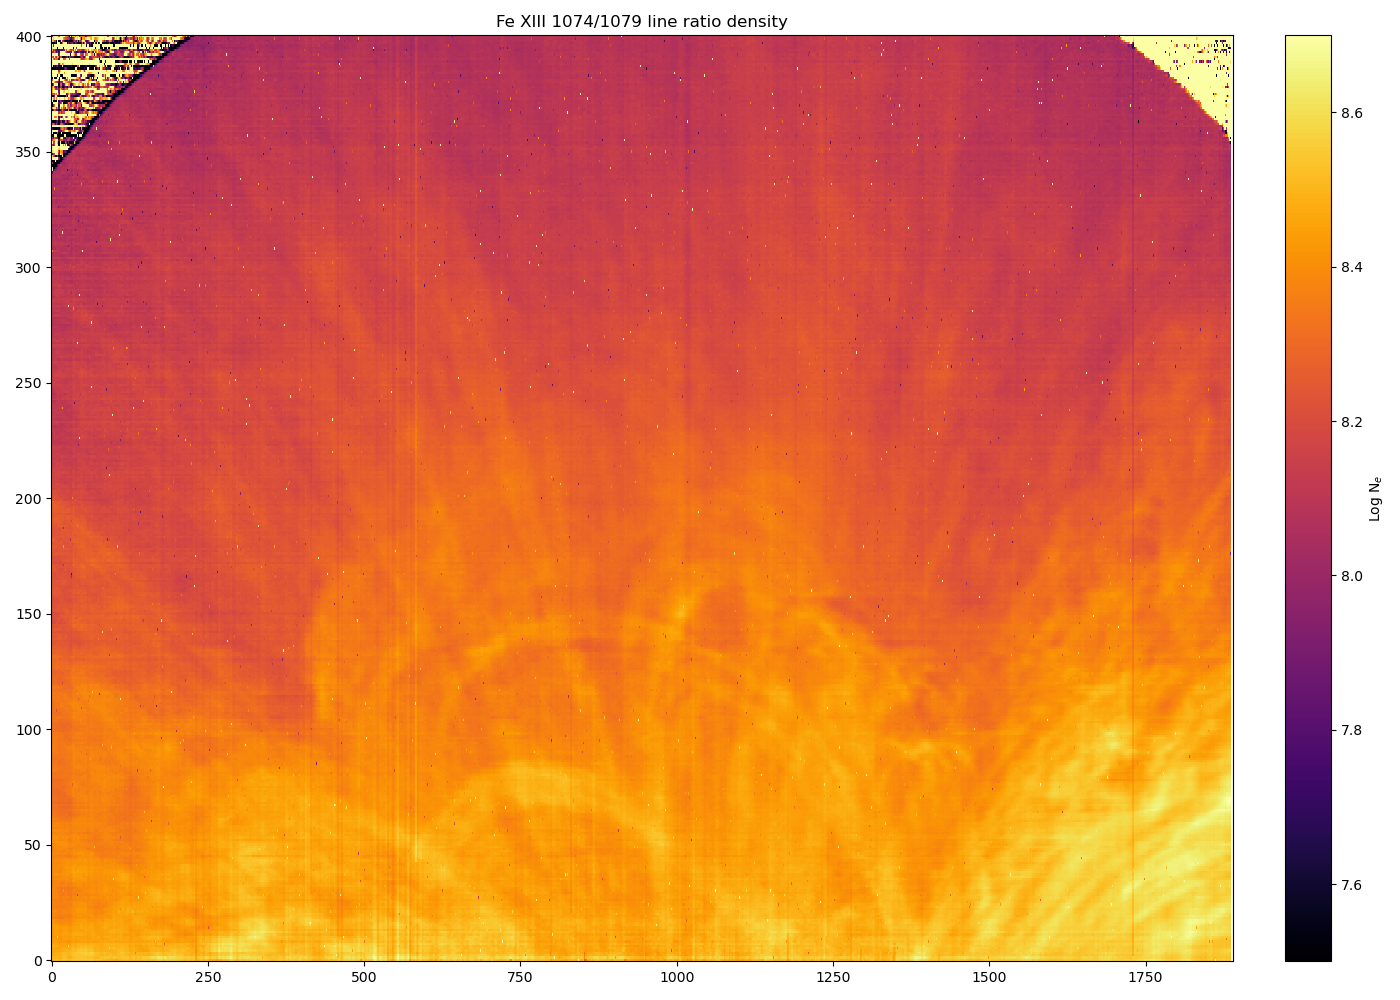

In [15]:
import matplotlib.pyplot as plt
%matplotlib widget

plt.figure(figsize=(14,10))
imc=plt.imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
plt.title("Fe XIII 1074/1079 peak line ratio density")
plt.colorbar(imc,label="Log N$_e$",fraction=0.038, pad=0.04)
plt.tight_layout()

/tmp/ipykernel_6791/3454091702.py:7: RuntimeWarning: divide by zero encountered in log10
  imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_6791/3454091702.py:7: RuntimeWarning: invalid value encountered in log10
  imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_6791/3454091702.py:11: RuntimeWarning: divide by zero encountered in log10
  imc=ax[1].imshow(np.log10(dens_rat_int),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_6791/3454091702.py:11: RuntimeWarning: invalid value encountered in log10
  imc=ax[1].imshow(np.log10(dens_rat_int),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
/tmp/ipykernel_6791/3454091702.py:15: RuntimeWarning: divide by zero encountered in log10
  imc=ax[2].imshow((np.log10(dens_rat_peak)-np.l

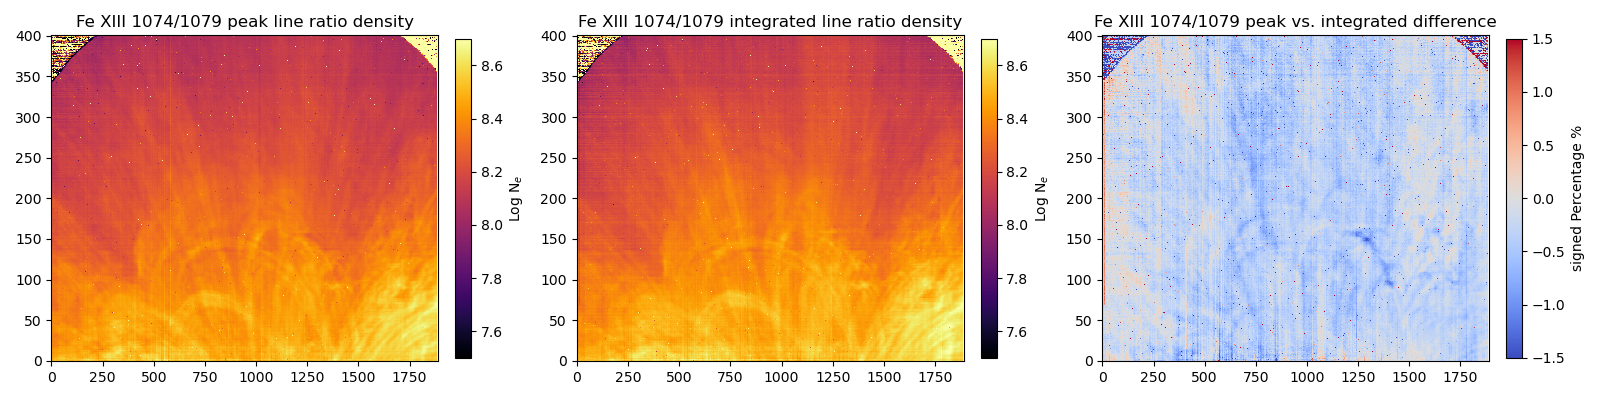

In [27]:
import matplotlib.pyplot as plt
%matplotlib widget

fig,ax = plt.subplots(1,3,figsize = (16,4),width_ratios=[0.33,0.33,0.33])
ax = ax.flatten()

imc=ax[0].imshow(np.log10(dens_rat_peak),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
ax[0].set_title("Fe XIII 1074/1079 peak line ratio density")
fig.colorbar(imc,label="Log N$_e$",fraction=0.038, pad=0.04)

imc=ax[1].imshow(np.log10(dens_rat_int),vmin=7.5,vmax=8.7,cmap='inferno',origin='lower',aspect="auto",interpolation="none")
ax[1].set_title("Fe XIII 1074/1079 integrated line ratio density")
fig.colorbar(imc,label="Log N$_e$",fraction=0.038, pad=0.04)

imc=ax[2].imshow((np.log10(dens_rat_peak)-np.log10(dens_rat_int))/9*100,vmin=-1.50,vmax=1.50,cmap='coolwarm',origin='lower',aspect="auto",interpolation="none")
ax[2].set_title("Fe XIII 1074/1079 peak vs. integrated difference")
fig.colorbar(imc,label="signed Percentage %",fraction=0.038, pad=0.04)


plt.tight_layout()